# Data Security Trends

### Background
A personal data breach means a breach of security leading to the accidental or unlawful destruction, loss, alteration, unauthorised disclosure of, or access to, personal data. This includes breaches that are the result of both accidental and deliberate causes. It also means that a breach is more than just about losing personal data.

When a personal data breach has occurred, organisations in the UK need to establish the likelihood of the risk to people’s rights and freedoms. If a risk is likely,they must notify the Information Commissioners Office(ICO). Failing to notify the ICO of a breach when required to do so can result in a heavy fine of up to £8.7 million or 2 per cent of your global turnover. 

### Raw Data Source
This notebook analysis data security incidents which have been reported to the ICO from the 4th quarter of 2018/19 fiscal year to the 4th quarter of 2020/21 fiscal year.

### Sorting the data
The data are organised by time into quarterly reports. These reports should be checked for correct headings and values to avoid duplication. Furthermore, the fiscal year in the UK starts in April therefore adjustments should be made to when translating into timestamp.

In [1]:
import pandas as pd
import numpy as np

# read in all the files
data2018q4 = pd.read_csv('data-security-figures-201819q4.csv')
data2019q1 = pd.read_csv('data-security-figures-201920q1.csv')
data2019q2 = pd.read_csv('data-security-figures-201920q2.csv')
data2019q3 = pd.read_csv('data-security-figures-201920q3.csv')
data2019q4 = pd.read_csv('data-security-figures-201920q4.csv')
data2020q1 = pd.read_csv('data-security-figures-202021q1.csv')
data2020q2 = pd.read_csv('data-security-figures-202021q2.csv')
data2020q3 = pd.read_csv('data-security-figures-202021q3.csv')
data2020q4 = pd.read_csv('data-security-figures-202021q4.csv')

datafileslist = [data2018q4,data2019q1,data2019q2, data2019q3, data2019q4, data2020q1, data2020q2, data2020q3, data2020q4]

# lowercase and replace any spaces with underscore for all column names
def underscore(name):
    name = name.replace(' ', '_')
    return name

def lower_header(data):
    data.columns = map(str.lower, data.columns)
    data.columns = map(underscore, data.columns)

def clean_files(datalist):
    for files in datalist:
        lower_header(files)

clean_files(datafileslist)

In [2]:
# Joins all the quarterly data into one table
fulldata = pd.concat(datafileslist, ignore_index=True)

# Duplicate a fiscal year column from year column. Note: In the UK the fiscal year Q1 starts in April.
fulldata['fyear'] = fulldata['year']
# Change year column to datetime object
fulldata['year']= pd.to_datetime(fulldata['year'], format='%Y')

# Function to turn fiscal year and quarter to calendar year dates. 
def change_dates(df):
    for i, row in df.iterrows():
        val = row['quarter']
        if val == 1:
            df.at[i, 'year'] = row['year'] + pd.DateOffset(months=6)
        elif val == 2:
            df.at[i, 'year'] = row['year'] + pd.DateOffset(months=9)
        elif val == 3:
            df.at[i, 'year'] = row['year'] + pd.DateOffset(months=12)
        elif val == 4:
            df.at[i, 'year'] = row['year'] + pd.DateOffset(months=15)

            
change_dates(fulldata)

# # Take one day away to represent the last day of the fiscal quarterly date
fulldata.loc[:, 'year'] = fulldata.loc[:, 'year'] - pd.DateOffset(days=1)

### Preview dataframe

In [3]:
fulldata.head()

,year,quarter,medium,incident_type,central_government,charitable_and_voluntary,education_and_childcare,"finance,_insurance_and_credit",general_business,health,...,political,regulators,religious,retail_and_manufacture,social_care,transport_and_leisure,utilities,grand_total,unassigned,fyear
0,2019-03-31,4.0,Non-cyber,Other non-cyber incident,18.0,24.0,78.0,63.0,83.0,149.0,...,1.0,1.0,NaN,27.0,3.0,15.0,7.0,602.0,NaN,2018.0
1,2019-03-31,4.0,Non-cyber,Data posted or faxed to incorrect recipient,171.0,5.0,27.0,67.0,29.0,90.0,...,NaN,1.0,NaN,1.0,1.0,7.0,5.0,536.0,NaN,2018.0
2,2019-03-31,4.0,Non-cyber,Data emailed to incorrect recipient,6.0,9.0,56.0,49.0,55.0,44.0,...,2.0,1.0,NaN,4.0,5.0,9.0,2.0,392.0,NaN,2018.0
3,2019-03-31,4.0,Non-cyber,Not Provided,15.0,28.0,45.0,49.0,45.0,63.0,...,1.0,1.0,2.0,21.0,1.0,15.0,2.0,384.0,NaN,2018.0
4,2019-03-31,4.0,Non-cyber,Loss/theft of paperwork or data left in insecu...,6.0,18.0,34.0,12.0,36.0,73.0,...,NaN,NaN,2.0,9.0,3.0,1.0,NaN,245.0,NaN,2018.0


### Create a database

In [4]:
# Create incident database
columnlist = list(fulldata.columns)
categories  = columnlist[columnlist.index("central_government"):columnlist.index("fyear")]

# Generating the query to create the schema for the table
query = 'CREATE TABLE incident(\nyear TEXT, \nquarter INT, \nmedium TEXT, \nincident_type TEXT, \n'
for category in categories:
    query += '{} INT, \n'.format(category)
query += 'fiscal_year INT, \nPRIMARY KEY (year, quarter, incident_type));'

In [5]:
import sqlite3

con = sqlite3.connect(':memory:')
cur = con.cursor()
cur.execute(query)
fulldata.to_sql('incident', con, if_exists='replace', index=False)

# Delete the "total" row from each quartely table
cur.execute("DELETE FROM incident WHERE incident_type='Non-cyber security incidents Total'")
cur.execute("DELETE FROM incident WHERE incident_type='Cyber Security Incidents Total'")
cur.fetchone()

## Data Analysis

### What proportion of incidents are cyber incidents?

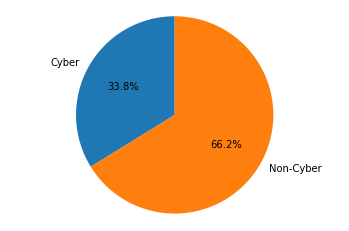

In [6]:
sql_cyber_grand_total = "SELECT SUM(grand_total) FROM incident WHERE medium='Cyber'"
cur.execute(sql_cyber_grand_total)
cyber = cur.fetchone()[0]

sql_non_cyber_grand_total = "SELECT SUM(grand_total) FROM incident WHERE medium='Non-cyber'"
cur.execute(sql_non_cyber_grand_total)
nonCyber = cur.fetchone()[0]

import matplotlib.pyplot as plt
labels = 'Cyber', 'Non-Cyber'
sizes = [cyber, nonCyber]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')

plt.show()

We can observe that the majority of data security incidents were Non-cyber incidents. Cyber incidents only accounted for a third of all incidents reported.

### What is the most frequently reported incident type in each category?
We can graphically represent the number of incidents according to the type of incidents. 

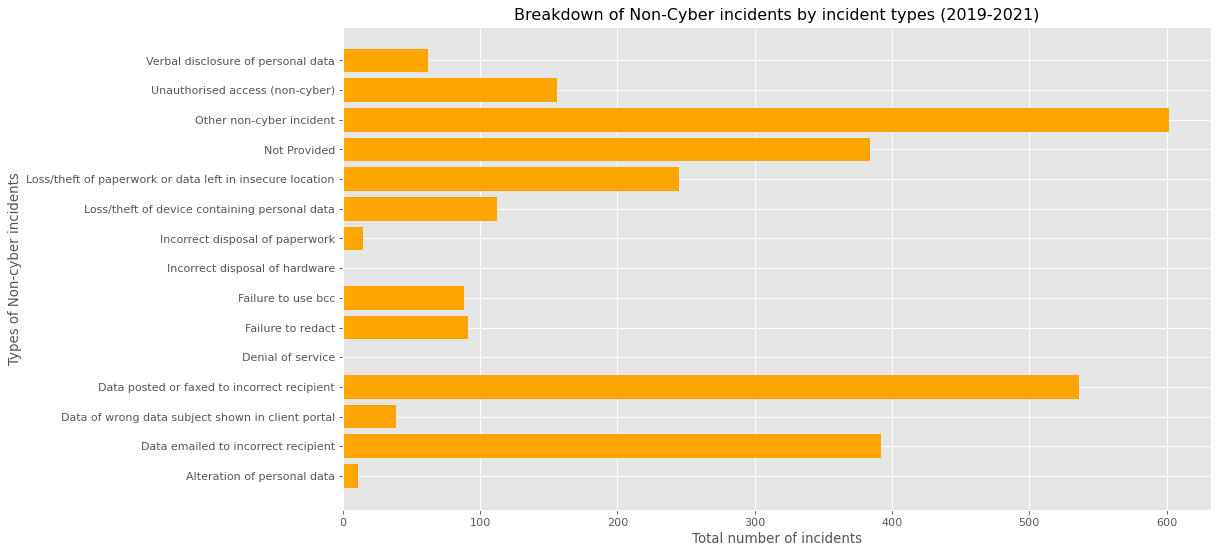

In [7]:
sql_non_cyber_incident_types = "SELECT incident_type, grand_total FROM incident WHERE medium='Non-cyber' GROUP BY incident_type"
cur.execute(sql_non_cyber_incident_types)
nonCyberIncidentTypes = cur.fetchall()
typesIncident, totalIncident =  zip(*nonCyberIncidentTypes)

types_pos = [i for i, _ in enumerate(typesIncident)]

from matplotlib.pyplot import figure
figure(figsize=(14,8), dpi=80)
plt.style.use('ggplot')
plt.barh(typesIncident, totalIncident, color='orange')
plt.xlabel('Total number of incidents')
plt.ylabel('Types of Non-cyber incidents')
plt.title('Breakdown of Non-Cyber incidents by incident types (2019-2021)')
plt.yticks(types_pos, typesIncident)
plt.show()

The most frequently reported incident type excluding "Other" is "Data posted or faxed to incorrent recipient". I find this quite surprising!

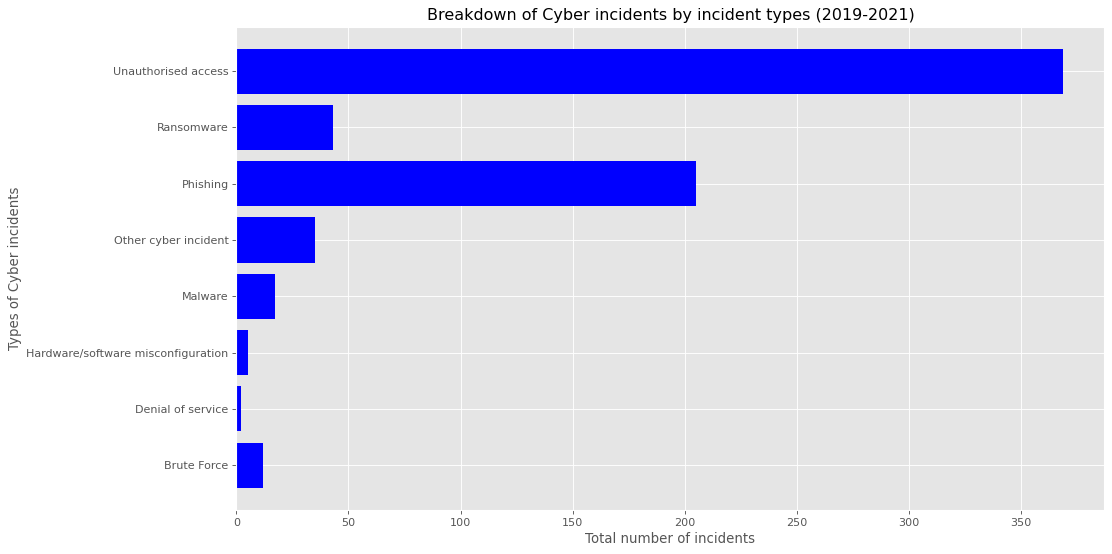

In [8]:
sql_cyber_incident_types = "SELECT incident_type, grand_total FROM incident WHERE medium='Cyber' GROUP BY incident_type"
cur.execute(sql_cyber_incident_types)
cyberIncidentTypes = cur.fetchall()

typesIncident, totalIncident =  zip(*cyberIncidentTypes)

types_pos = [i for i, _ in enumerate(typesIncident)]

figure(figsize=(14,8), dpi=80)
plt.style.use('ggplot')
plt.barh(typesIncident, totalIncident, color='blue')
plt.xlabel('Total number of incidents')
plt.ylabel('Types of Cyber incidents')
plt.title('Breakdown of Cyber incidents by incident types (2019-2021)')
plt.yticks(types_pos, typesIncident)
plt.show()

"Unauthorised access" is the most frequently reported incident in the cyber incidents category.

## How are the types of cyber incidents changing with respect to time?

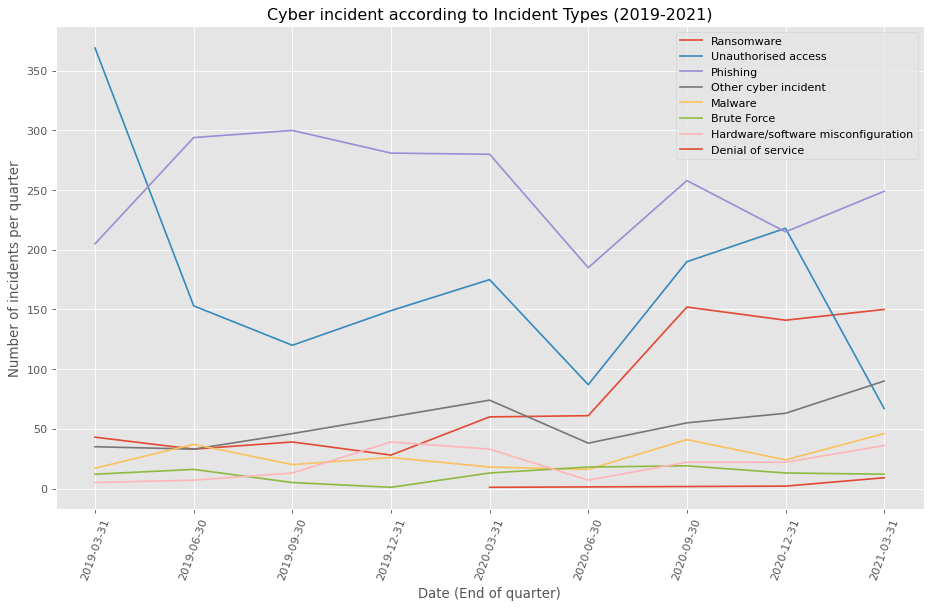

In [9]:
sql_cyber_types = "SELECT DISTINCT incident_type FROM incident WHERE medium='Cyber'"
cur.execute(sql_cyber_types)
results = cur.fetchall()
listOfCyberTypes=[]

# A list of cyber incident types without ransomware
for types in results:
    if types == ('Ransomware',):
        pass
    else:
        listOfCyberTypes += list(types)

figure(figsize=(14,8), dpi=80)
plt.style.use('ggplot')

sql_ransomware = "SELECT year, grand_total FROM incident WHERE incident_type='Ransomware'"
cur.execute(sql_ransomware)
results = cur.fetchall()
x, y = zip(*results)
x_list = list(x)
for i, date in enumerate(x_list):
    x_list[i] = date[:10]
plt.plot(x, y, label='Ransomware')

# Generate graphs for all incident types
def plt_graph(incidentType):
    sql_dates = "SELECT year, grand_total FROM incident WHERE incident_type='{}'".format(incidentType)
    cur.execute(sql_dates)
    listincident = list(cur.fetchall())
    x, y = zip(*listincident)
    plt.plot(x, y, label='{}'.format(incidentType))
    
    
for types in listOfCyberTypes:
    plt_graph(types)

plt.xticks(x, x_list, rotation=70)   
plt.xlabel("Date (End of quarter)")
plt.ylabel("Number of incidents per quarter")
plt.title("Cyber incident according to Incident Types (2019-2021)")
plt.legend()
plt.show()

## A Closer Look at Ransomware

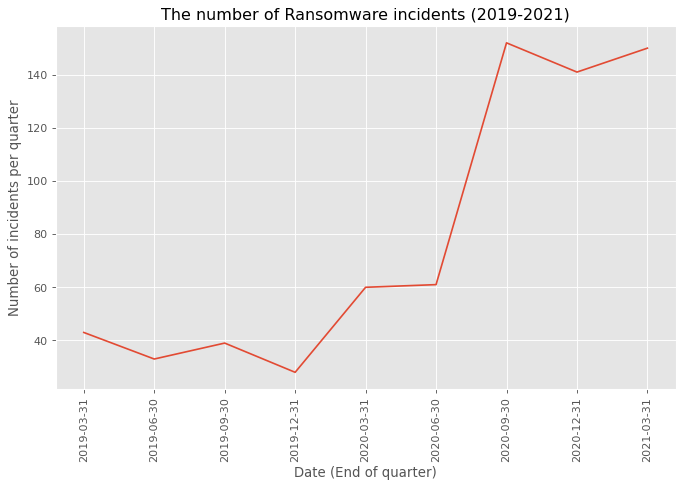

In [10]:
figure(figsize=(10,6), dpi=80)
plt.style.use('ggplot')
plt.plot(x, y, label='Ransomware')
plt.xticks(x, x_list, rotation=90)
plt.xlabel("Date (End of quarter)")
plt.ylabel("Number of incidents per quarter")
plt.title("The number of Ransomware incidents (2019-2021)")
plt.show()

Wow! That is a massive increase in ransomware incidents.

### What industry had the most ransomware incidents from (2019-2021)?

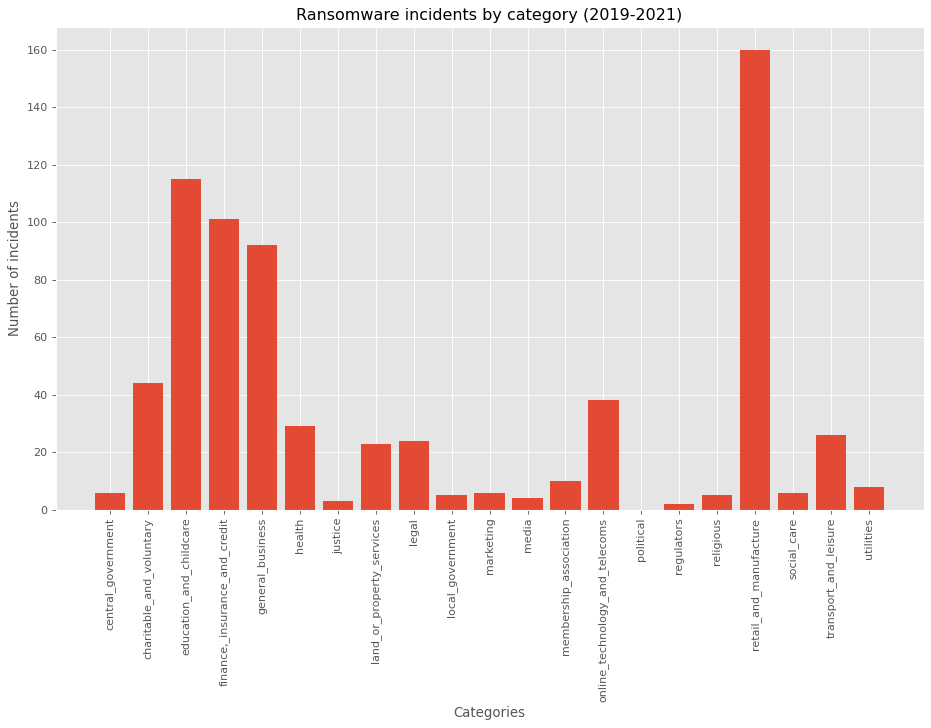

In [11]:
sql_ransomware_industry = "SELECT * FROM incident WHERE incident_type='Ransomware'"
cur.execute(sql_ransomware_industry)
ransomware_results = cur.fetchall()

df_ransomware = pd.DataFrame(ransomware_results, columns=fulldata.columns)
df_ransomware.head()
ransomware_by_industry = df_ransomware[categories].sum(skipna=True)

#remove grand total and unassigned attributes
ransomware_by_industry = ransomware_by_industry[:-2]

figure(figsize=(14,8), dpi=80)
plt.style.use('ggplot')

x = ransomware_by_industry.index
y = ransomware_by_industry.values

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x, y)
plt.xlabel("Categories")
plt.ylabel("Number of incidents")
plt.title("Ransomware incidents by category (2019-2021)")
plt.xticks(x_pos, x, rotation=90)
plt.show()

"Retail and Manufacture" industry had the most ransomware incidents from (2019 - 2021)